# Test-Negative Design Simulation with Antibody Dynamics

This notebook demonstrates a test-negative design simulation that incorporates antibody dynamics and waning immunity. The simulation models:

- **Two pathogens**: test-negative pathogen (unaffected by vaccination) and test-positive pathogen (affected by vaccination)
- **Antibody levels**: Individual-level antibody concentrations that provide protection against infection
- **Antibody waning**: Gradual decline in antibody levels over time
- **Vaccination effects**: Boost antibodies for test-positive pathogen only
- **Infection-induced immunity**: Natural infection boosts antibodies for the respective pathogen
- **Network-based transmission**: Disease spread through social contacts
- **Test-negative design analysis**: Estimate vaccine effectiveness using antibody levels measured at time of testing

## Key Features
- **Antibody-mediated protection**: Higher antibody levels provide better protection (0 = no protection, 1 = complete protection)
- **Differential vaccination effects**: Vaccine only affects test-positive pathogen antibodies and susceptibility
- **Realistic immunity waning**: Antibody levels decline over time, reducing protection
- **Test-negative design focus**: Uses antibody levels at time of testing for protection estimates
- **Spline-based dose-response**: Flexible modeling of antibody-protection relationships

## 1. Import Libraries and Load Simulation Code

In [1]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import SplineTransformer
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load simulation functions from utils.py
from utils import (
    generate_random_graph, 
    assign_initial_states, 
    assign_initial_infected,
    assign_vaccine,
    update_antibody_levels,
    get_protection_factor,
    simulate_outbreaks,
    estimate_models,
    run_simulation,
    compute_bias_mse,
    scaled_logit
)

print("All libraries and functions loaded successfully!")

All libraries and functions loaded successfully!


## 2. Set Simulation Parameters

Define the default parameters for our test-negative design simulation, including antibody dynamics.

In [2]:
# Default simulation parameters
PARAMS = {
    'num_nodes': 10000,                     # Size of the population
    'edges_per_node': 10,                   # Average connections per person
    'infection_prob': (0.03, 0.04),        # Base infection probabilities (test_neg, test_pos)
    'recovery_prob': (0.15, 0.15),         # Recovery probabilities per time step
    'testing_prob': (0.4, 0.4),            # Base testing probabilities
    'vaccine_prob': 0.35,                  # Probability of being vaccinated
    'num_initial_infected': (50, 25),      # Initial infected individuals (test_neg, test_pos)
    'steps': 60,                          # Number of time steps to simulate
    
    # Antibody parameters
    'antibody_max_vacc': 0.99,              # Maximum antibody level from vaccination
    'antibody_max_inf': 0.99,               # Maximum antibody level from infection  
    'antibody_waning': 0.015,              # Antibody waning per time step (1.5% per step)
    'scaled_logit': True
}

print("Simulation Parameters:")
for key, value in PARAMS.items():
    print(f"  {key}: {value}")

print(f"\nKey Features:")
print(f"  - Vaccine only protects against test-positive pathogen")
print(f"  - Antibody levels: 0 = no protection, 1 = complete protection")
print(f"  - Antibody waning: {PARAMS['antibody_waning']*100:.1f}% per time step")
print(f"  - Natural infection provides higher antibody peak than vaccination")
print(f"  - Analysis uses antibody levels measured at time of testing")

Simulation Parameters:
  num_nodes: 10000
  edges_per_node: 10
  infection_prob: (0.03, 0.04)
  recovery_prob: (0.15, 0.15)
  testing_prob: (0.4, 0.4)
  vaccine_prob: 0.35
  num_initial_infected: (50, 25)
  steps: 60
  antibody_max_vacc: 0.99
  antibody_max_inf: 0.99
  antibody_waning: 0.015
  scaled_logit: True

Key Features:
  - Vaccine only protects against test-positive pathogen
  - Antibody levels: 0 = no protection, 1 = complete protection
  - Antibody waning: 1.5% per time step
  - Natural infection provides higher antibody peak than vaccination
  - Analysis uses antibody levels measured at time of testing


## 3. Run Basic Test-Negative Design Simulation

Let's run a basic simulation to see how the epidemic progresses with antibody dynamics and vaccination.

Running basic test-negative design simulation...
Step 0: Infected (Test Neg): 61, Infected (Test Pos): 24
	Tested (Neg): 11, Tested (Pos): 2
	Avg Antibody (Neg): 0.005, Avg Antibody (Pos): 0.186
Step 10: Infected (Test Neg): 228, Infected (Test Pos): 96
	Tested (Neg): 177, Tested (Pos): 76
	Avg Antibody (Neg): 0.019, Avg Antibody (Pos): 0.141
Step 20: Infected (Test Neg): 763, Infected (Test Pos): 528
	Tested (Neg): 812, Tested (Pos): 427
	Avg Antibody (Neg): 0.085, Avg Antibody (Pos): 0.132
Step 30: Infected (Test Neg): 1312, Infected (Test Pos): 1470
	Tested (Neg): 1706, Tested (Pos): 1365
	Avg Antibody (Neg): 0.228, Avg Antibody (Pos): 0.234
Step 40: Infected (Test Neg): 1173, Infected (Test Pos): 1818
	Tested (Neg): 2267, Tested (Pos): 2229
	Avg Antibody (Neg): 0.366, Avg Antibody (Pos): 0.414
Step 50: Infected (Test Neg): 784, Infected (Test Pos): 1201
	Tested (Neg): 2567, Tested (Pos): 2679
	Avg Antibody (Neg): 0.432, Avg Antibody (Pos): 0.527


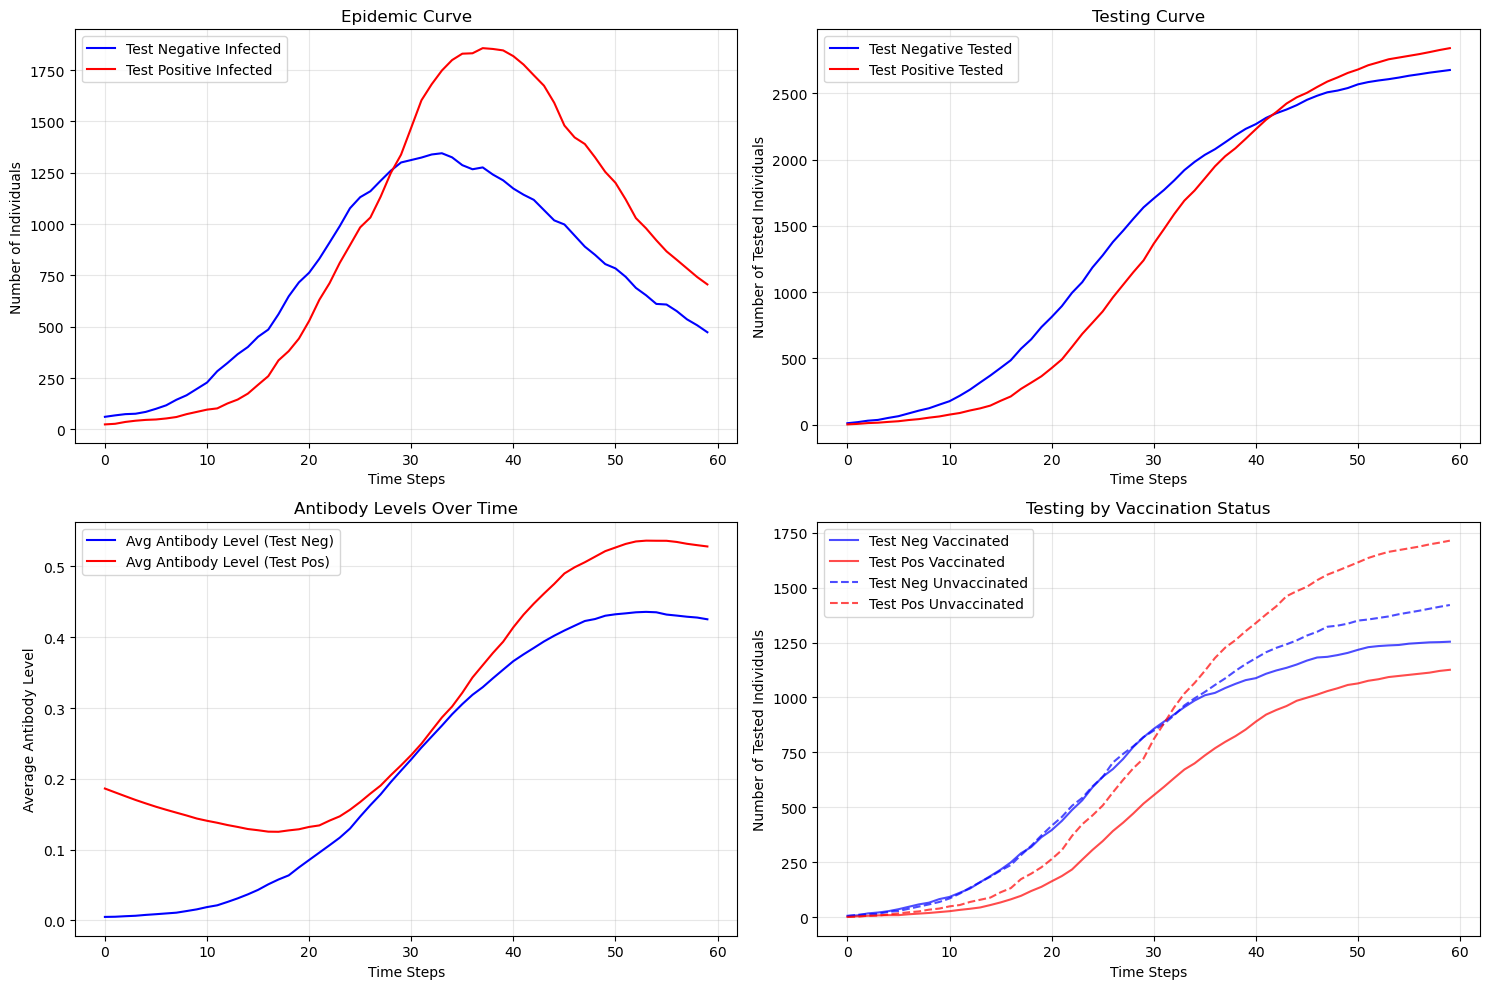

=== TEST-NEGATIVE DESIGN ANALYSIS (antibody levels at time of testing) ===
Antibody levels: [0.01 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.99]
=== SPLINE ===
Antibody-based Protection: [0.         0.01972503 0.23256477 0.47455203 0.65094769 0.75042479
 0.79271192 0.80370501 0.79618308 0.77684763 0.75470128]
=== LOG-TRANSFORMED ===
Antibody-based Protection: [0.         0.06712615 0.14388819 0.22330267 0.30586384 0.39225965
 0.48350464 0.58122514 0.68839648 0.81200846 0.96491718]

=== VACCINATION-BASED TND (for comparison) ===
Vaccination TND HR: 0.751
Vaccination TND VE: 24.9%

=== BASIC SIMULATION RESULTS ===
Test Negative Design HR (vaccination): 0.751
Test Negative Design VE (vaccination): 24.9%

Antibody-based Protection Curve Available: Yes
Antibody levels tested: [0.01 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.99]
Protection (spline) values: [0.         0.01972503 0.23256477 0.47455203 0.65094769 0.75042479
 0.79271192 0.80370501 0.79618308 0.77684763 0.75470128]
Prote

In [3]:
# Run basic simulation with default parameters
print("Running basic test-negative design simulation...")
G_basic, results_basic = run_simulation(
    **PARAMS,
    plot=True,
    print_progress=True,
)

print("\n=== BASIC SIMULATION RESULTS ===")
if results_basic['hr_test_negative_design'] is not None:
    print(f"Test Negative Design HR (vaccination): {results_basic['hr_test_negative_design']:.3f}")
    ve_tnd = (1 - results_basic['hr_test_negative_design']) * 100
    print(f"Test Negative Design VE (vaccination): {ve_tnd:.1f}%")
else:
    print("Test Negative Design: Could not estimate (insufficient data)")

# Check if we have antibody-based protection curve
if results_basic['protection_spline'] is not None:
    print(f"\nAntibody-based Protection Curve Available: Yes")
    print(f"Antibody levels tested: {results_basic['antibody_grid']}")
    print(f"Protection (spline) values: {results_basic['protection_spline']}")
    print(f"Protection (log) values: {results_basic['protection_log']}")
else:
    print(f"\nAntibody-based Protection Curve Available: No (insufficient data)")

# Show antibody analysis results
print(f"\n=== ANTIBODY ANALYSIS ===")
model_results = results_basic['model_results']
if model_results['protection_spline'] is not None:
    antibody_levels = model_results['antibody_grid']
    protection = model_results['protection_spline']
    
    # Find protection at different antibody levels
    low_ab_protection = protection[1]  # Protection at 0.1 antibody level
    mid_ab_protection = protection[5]  # Protection at 0.5 antibody level  
    high_ab_protection = protection[9] # Protection at 0.9 antibody level
    
    print(f"Protection at low antibody (0.1): {low_ab_protection:.3f}")
    print(f"Protection at medium antibody (0.5): {mid_ab_protection:.3f}")
    print(f"Protection at high antibody (0.9): {high_ab_protection:.3f}")
else:
    print("Could not estimate antibody-based protection curve")

if model_results['protection_log'] is not None:
    antibody_levels = model_results['antibody_grid']
    protection = model_results['protection_log']
    
    # Find protection at different antibody levels
    low_ab_protection = protection[1]  # Protection at 0.1 antibody level
    mid_ab_protection = protection[5]  # Protection at 0.5 antibody level  
    high_ab_protection = protection[9] # Protection at 0.9 antibody level
    
    print(f"Protection at low antibody (0.1): {low_ab_protection:.3f}")
    print(f"Protection at medium antibody (0.5): {mid_ab_protection:.3f}")
    print(f"Protection at high antibody (0.9): {high_ab_protection:.3f}")
else:
    print("Could not estimate antibody-based protection curve")

## 4. Visualize Antibody Dynamics Over Time

Let's examine how antibody levels change over time and how they differ between vaccinated and unvaccinated individuals.

=== FINAL ANTIBODY LEVEL ANALYSIS ===
Vaccinated individuals (n=3746):
  Test Neg Antibody: 0.461 ± 0.327
  Test Pos Antibody: 0.544 ± 0.328

Unvaccinated individuals (n=6254):
  Test Neg Antibody: 0.404 ± 0.346
  Test Pos Antibody: 0.519 ± 0.328

=== ANTIBODY LEVELS AT TIME OF TESTING ===
Individuals who were tested (n=5515):
  Test Neg Antibody at testing: 0.092 ± 0.259
  Test Pos Antibody at testing: 0.151 ± 0.275

By test outcome:
  Test-negative results (n=2675):
    Test Pos Antibody at testing: 0.221 ± 0.319
  Test-positive results (n=2840):
    Test Pos Antibody at testing: 0.085 ± 0.205


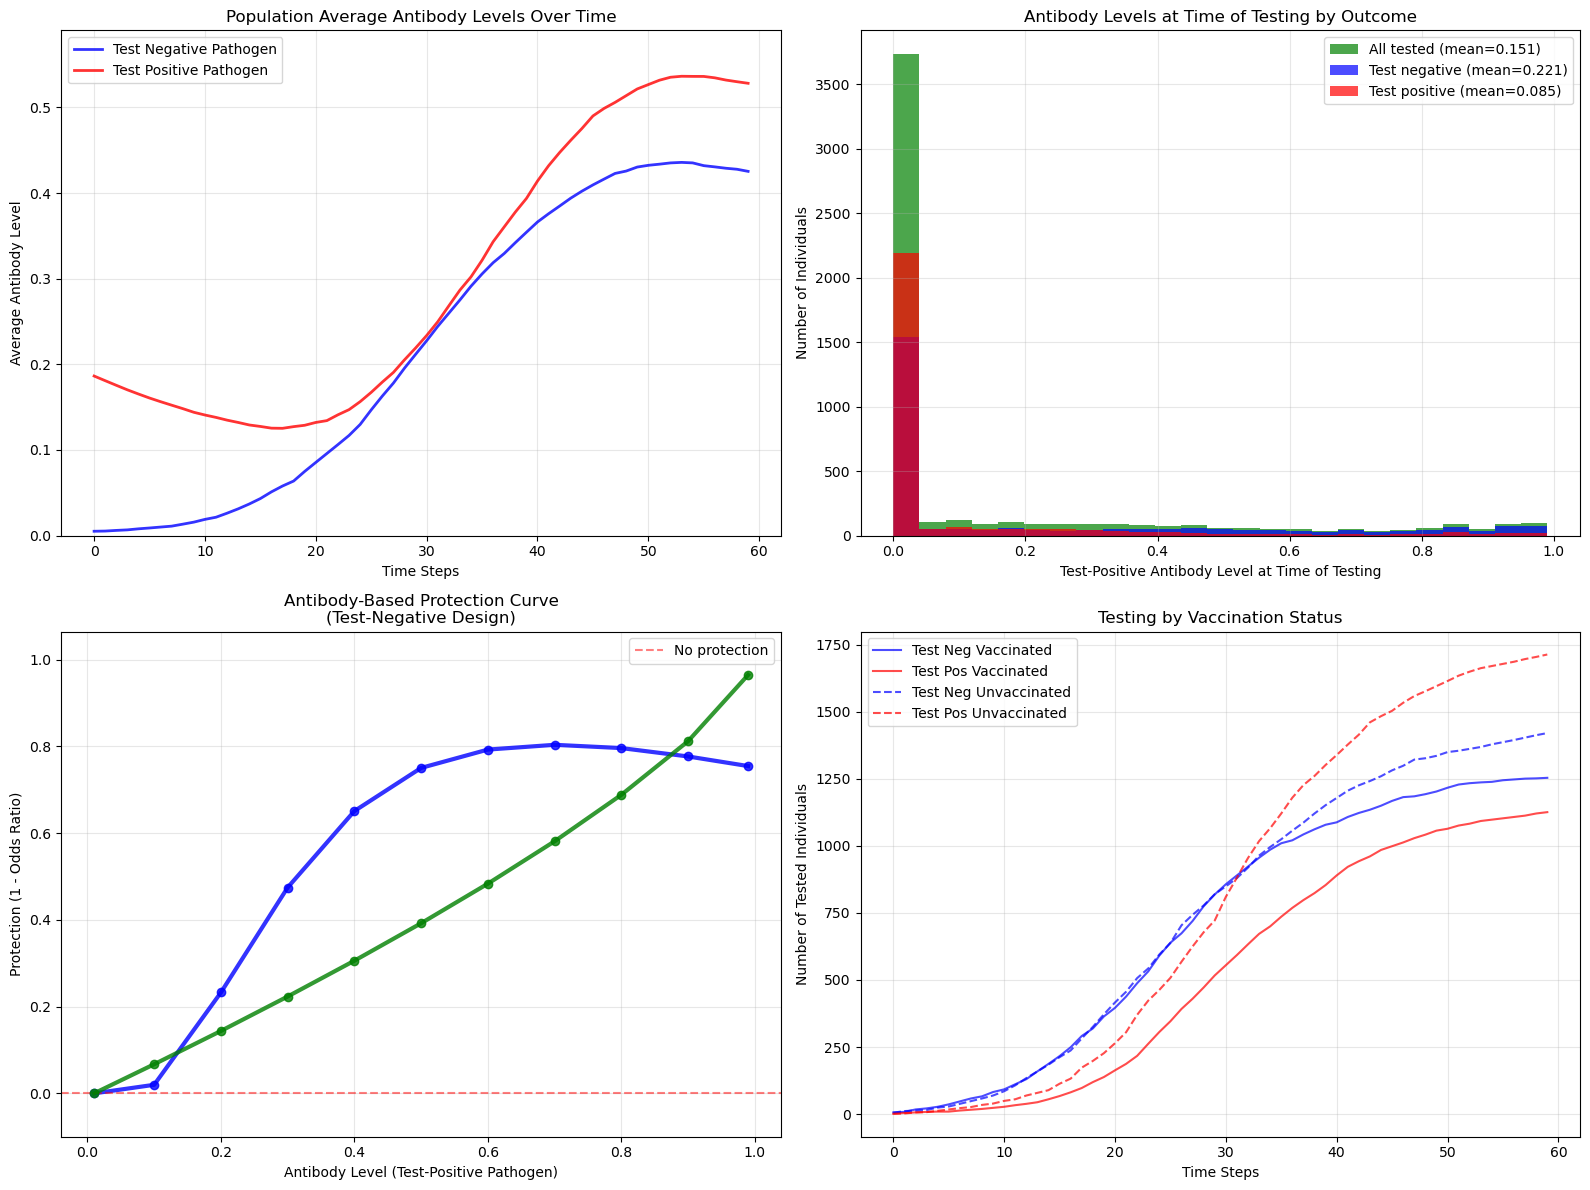


Key Observations:
  - Vaccinated individuals have higher test-positive antibody levels
  - Test-negative pathogen antibodies are similar regardless of vaccination
  - Antibody levels at testing show dose-response relationship with outcomes
  - Population average antibody levels decline over time due to waning
  - Protection increases with higher antibody levels (spline-based curve)
  - Protection increases with higher antibody levels (log)


In [4]:
# Extract final antibody levels by vaccination status
data = pd.DataFrame.from_dict(dict(G_basic.nodes(data=True)), orient='index')

# Analyze antibody levels by vaccination status
vaccinated_data = data[data['vaccinated'] == True]
unvaccinated_data = data[data['vaccinated'] == False]

print("=== FINAL ANTIBODY LEVEL ANALYSIS ===")
print(f"Vaccinated individuals (n={len(vaccinated_data)}):")
print(f"  Test Neg Antibody: {vaccinated_data['antibody_level_1'].mean():.3f} ± {vaccinated_data['antibody_level_1'].std():.3f}")
print(f"  Test Pos Antibody: {vaccinated_data['antibody_level_2'].mean():.3f} ± {vaccinated_data['antibody_level_2'].std():.3f}")

print(f"\nUnvaccinated individuals (n={len(unvaccinated_data)}):")
print(f"  Test Neg Antibody: {unvaccinated_data['antibody_level_1'].mean():.3f} ± {unvaccinated_data['antibody_level_1'].std():.3f}")
print(f"  Test Pos Antibody: {unvaccinated_data['antibody_level_2'].mean():.3f} ± {unvaccinated_data['antibody_level_2'].std():.3f}")

# Analyze antibody levels at time of testing
tested_data = data[(data['T1']) | (data['T2'])].copy()
tested_data = tested_data.dropna(subset=['antibody_level_2_at_test'])

if len(tested_data) > 0:
    print(f"\n=== ANTIBODY LEVELS AT TIME OF TESTING ===")
    print(f"Individuals who were tested (n={len(tested_data)}):")
    print(f"  Test Neg Antibody at testing: {tested_data['antibody_level_1_at_test'].mean():.3f} ± {tested_data['antibody_level_1_at_test'].std():.3f}")
    print(f"  Test Pos Antibody at testing: {tested_data['antibody_level_2_at_test'].mean():.3f} ± {tested_data['antibody_level_2_at_test'].std():.3f}")
    
    # Compare by test outcome
    test_negative = tested_data[tested_data['T1'] == True]
    test_positive = tested_data[tested_data['T2'] == True]
    
    if len(test_negative) > 0 and len(test_positive) > 0:
        print(f"\nBy test outcome:")
        print(f"  Test-negative results (n={len(test_negative)}):")
        print(f"    Test Pos Antibody at testing: {test_negative['antibody_level_2_at_test'].mean():.3f} ± {test_negative['antibody_level_2_at_test'].std():.3f}")
        print(f"  Test-positive results (n={len(test_positive)}):")
        print(f"    Test Pos Antibody at testing: {test_positive['antibody_level_2_at_test'].mean():.3f} ± {test_positive['antibody_level_2_at_test'].std():.3f}")

# Create comprehensive visualization including antibody-based protection curve
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Average antibody levels over time from time series
time_series = results_basic['time_series']
steps = len(time_series['antibody_1_over_time'])
ax1.plot(range(steps), time_series['antibody_1_over_time'], 'b-', linewidth=2, 
         label='Test Negative Pathogen', alpha=0.8)
ax1.plot(range(steps), time_series['antibody_2_over_time'], 'r-', linewidth=2, 
         label='Test Positive Pathogen', alpha=0.8)
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Average Antibody Level')
ax1.set_title('Population Average Antibody Levels Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, max(max(time_series['antibody_1_over_time']), max(time_series['antibody_2_over_time'])) * 1.1)

# Plot 2: Antibody levels at time of testing
if len(tested_data) > 0:
    ax2.hist(tested_data['antibody_level_2_at_test'], bins=25, alpha=0.7, color='green',
             label=f'All tested (mean={tested_data["antibody_level_2_at_test"].mean():.3f})')
    if len(test_negative) > 0:
        ax2.hist(test_negative['antibody_level_2_at_test'], bins=25, alpha=0.7, color='blue',
                 label=f'Test negative (mean={test_negative["antibody_level_2_at_test"].mean():.3f})')
    if len(test_positive) > 0:
        ax2.hist(test_positive['antibody_level_2_at_test'], bins=25, alpha=0.7, color='red',
                 label=f'Test positive (mean={test_positive["antibody_level_2_at_test"].mean():.3f})')
    ax2.set_xlabel('Test-Positive Antibody Level at Time of Testing')
    ax2.set_ylabel('Number of Individuals')
    ax2.set_title('Antibody Levels at Time of Testing by Outcome')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No testing data available', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Antibody Levels at Time of Testing')

# Plot 3: Antibody-based protection curve (spline)
if results_basic['protection_spline'] is not None:
    antibody_grid = results_basic['antibody_grid']
    protection = results_basic['protection_spline']
    ax3.plot(antibody_grid, protection, 'g-o', linewidth=3, markersize=6, alpha=0.8, color = 'blue')
    ax3.set_xlabel('Antibody Level (Test-Positive Pathogen)')
    ax3.set_ylabel('Protection (1 - Odds Ratio)')
    ax3.set_title('Antibody-Based Protection Curve\n(Test-Negative Design)')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='No protection')
    ax3.set_ylim(min(protection) - 0.1, max(protection) + 0.1)
    ax3.legend()
else:
    ax3.text(0.5, 0.5, 'Protection curve not available\n(insufficient data)', 
             ha='center', va='center', transform=ax3.transAxes)

# Plot 3: Antibody-based protection curve (log)
if results_basic['protection_log'] is not None:
    antibody_grid = results_basic['antibody_grid']
    protection = results_basic['protection_log']
    ax3.plot(antibody_grid, protection, 'g-o', linewidth=3, markersize=6, alpha=0.8)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(min(protection) - 0.1, max(protection) + 0.1)
    ax3.legend()
    

# Plot 5: Testing curve by vaccination status
ax4.plot(range(steps), time_series['tested_1_over_time_vaccinated'], label='Test Neg Vaccinated', color='blue', linestyle='-', alpha=0.7)
ax4.plot(range(steps), time_series['tested_2_over_time_vaccinated'], label='Test Pos Vaccinated', color='red', linestyle='-', alpha=0.7)
ax4.plot(range(steps), time_series['tested_1_over_time_unvaccinated'], label='Test Neg Unvaccinated', color='blue', linestyle='--', alpha=0.7)
ax4.plot(range(steps), time_series['tested_2_over_time_unvaccinated'], label='Test Pos Unvaccinated', color='red', linestyle='--', alpha=0.7)
ax4.set_xlabel('Time Steps')
ax4.set_ylabel('Number of Tested Individuals')
ax4.set_title('Testing by Vaccination Status')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKey Observations:")
print(f"  - Vaccinated individuals have higher test-positive antibody levels")
print(f"  - Test-negative pathogen antibodies are similar regardless of vaccination")
print(f"  - Antibody levels at testing show dose-response relationship with outcomes")
print(f"  - Population average antibody levels decline over time due to waning")
if results_basic['protection_spline'] is not None:
    print(f"  - Protection increases with higher antibody levels (spline-based curve)")
if results_basic['protection_log'] is not None:
    print(f"  - Protection increases with higher antibody levels (log)")

## 5. Compare Different Antibody Waning Rates

Let's compare how different rates of antibody waning affect vaccine effectiveness estimates and epidemic dynamics.

Comparing different antibody waning rates...

Running: No Waning (0%)
  TND VE (vaccination): 58.8%
  Protection at high antibody (80%): 84.2%

Running: Slow Waning (0.5%)
  TND VE (vaccination): 43.6%
  Protection at high antibody (80%): 78.7%

Running: Medium Waning (1.5%)
  TND VE (vaccination): 14.8%
  Protection at high antibody (80%): 81.5%

Running: Fast Waning (3%)
  TND VE (vaccination): -3.9%
  Protection at high antibody (80%): 83.7%

Running: Very Fast Waning (5%)
  TND VE (vaccination): 4.9%
  Protection at high antibody (80%): 77.6%


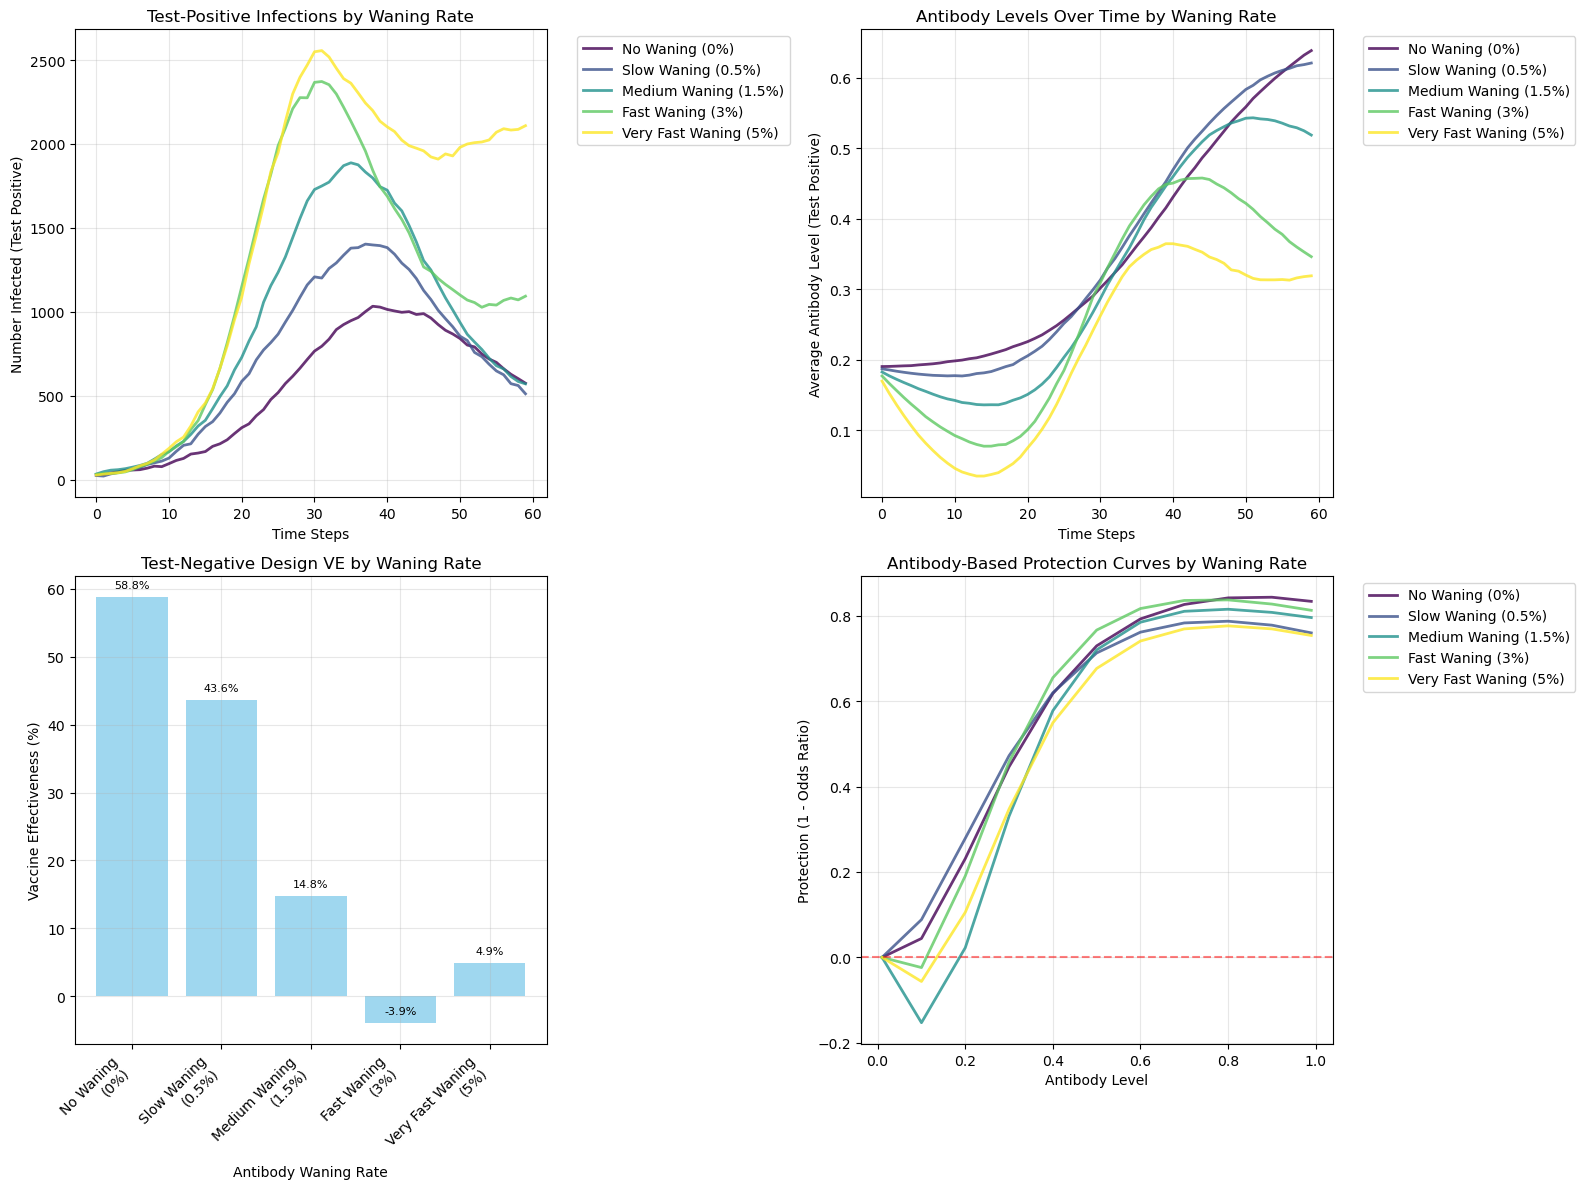


=== WANING RATE COMPARISON SUMMARY ===

No Waning (0%):
  Peak test-pos infections: 1034
  Final avg antibody level: 0.639
  TND VE (vaccination): 58.8%
  Max antibody protection: 84.3%

Slow Waning (0.5%):
  Peak test-pos infections: 1404
  Final avg antibody level: 0.621
  TND VE (vaccination): 43.6%
  Max antibody protection: 78.7%

Medium Waning (1.5%):
  Peak test-pos infections: 1888
  Final avg antibody level: 0.519
  TND VE (vaccination): 14.8%
  Max antibody protection: 81.5%

Fast Waning (3%):
  Peak test-pos infections: 2372
  Final avg antibody level: 0.346
  TND VE (vaccination): -3.9%
  Max antibody protection: 83.7%

Very Fast Waning (5%):
  Peak test-pos infections: 2556
  Final avg antibody level: 0.319
  TND VE (vaccination): 4.9%
  Max antibody protection: 77.6%
=== DETAILED ANTIBODY PROTECTION ANALYSIS ===


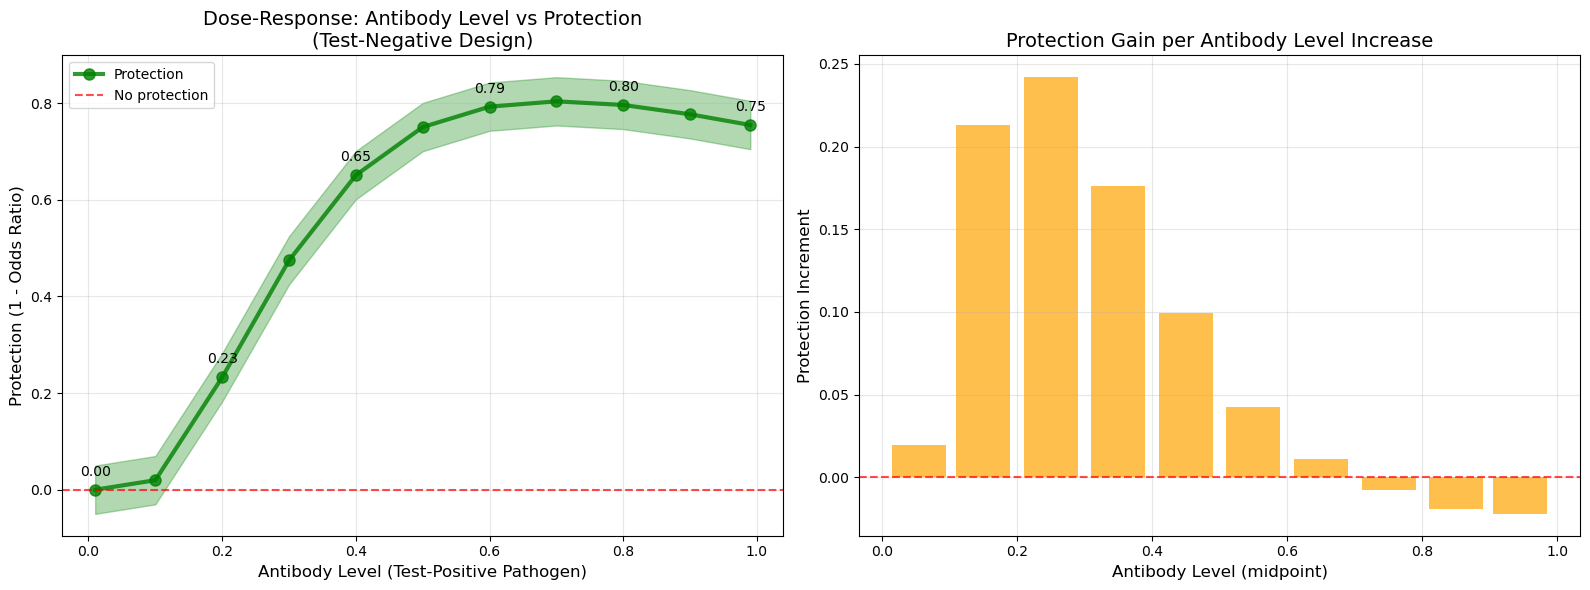


Protection at different antibody levels:
  Antibody 0.0: Protection = 0.000 (VE = 0.0%)
  Antibody 0.1: Protection = 0.020 (VE = 2.0%)
  Antibody 0.2: Protection = 0.233 (VE = 23.3%)
  Antibody 0.3: Protection = 0.475 (VE = 47.5%)
  Antibody 0.4: Protection = 0.651 (VE = 65.1%)
  Antibody 0.5: Protection = 0.750 (VE = 75.0%)
  Antibody 0.6: Protection = 0.793 (VE = 79.3%)
  Antibody 0.7: Protection = 0.804 (VE = 80.4%)
  Antibody 0.8: Protection = 0.796 (VE = 79.6%)
  Antibody 0.9: Protection = 0.777 (VE = 77.7%)
  Antibody 1.0: Protection = 0.755 (VE = 75.5%)

Summary Statistics:
  Maximum protection: 0.804 (80.4% VE)
  Minimum protection: 0.000 (0.0% VE)
  Protection range: 0.804
  Average protection increment: 0.075

=== SPLINE MODELING DETAILS ===
The test-negative design uses restricted cubic splines to model the
relationship between antibody levels and odds of testing positive.
This allows for flexible, non-linear dose-response relationships.
- Spline knots: 3
- Spline degree: 3

In [5]:
# Define different antibody waning rates to test
waning_rates = {
    'No Waning (0%)': 0.0,
    'Slow Waning (0.5%)': 0.005, 
    'Medium Waning (1.5%)': 0.015,
    'Fast Waning (3%)': 0.03,
    'Very Fast Waning (5%)': 0.05
}

# Run simulations for each waning rate
waning_results = {}
print("Comparing different antibody waning rates...")

for waning_name, waning_rate in waning_rates.items():
    print(f"\nRunning: {waning_name}")
    
    # Create modified parameters
    test_params = PARAMS.copy()
    test_params['antibody_waning'] = waning_rate
    
    # Run simulation (no plots for comparison runs)
    G, results = run_simulation(
        **test_params,
        plot=False,
        print_progress=False
    )
    
    waning_results[waning_name] = results
    
    # Print key estimates
    if results['hr_test_negative_design'] is not None:
        ve_tnd = (1 - results['hr_test_negative_design']) * 100
        print(f"  TND VE (vaccination): {ve_tnd:.1f}%")
    else:
        print(f"  TND VE: Could not estimate")
    
    if results['protection_spline'] is not None:
        # Calculate protection at high antibody level (0.8)
        high_ab_protection = results['protection_spline'][8] * 100  # Index 8 ≈ 0.8 antibody level
        print(f"  Protection at high antibody (80%): {high_ab_protection:.1f}%")

# Create comparison visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

#Colors for different waning rates
colors = plt.cm.viridis(np.linspace(0, 1, len(waning_rates)))

# Plot 1: Test-positive pathogen infections over time
for i, (name, rate) in enumerate(waning_rates.items()):
    infected_data = waning_results[name]['time_series']['infected_2_over_time']
    ax1.plot(range(len(infected_data)), infected_data, label=name, 
             linewidth=2, alpha=0.8, color=colors[i])

ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Number Infected (Test Positive)')
ax1.set_title('Test-Positive Infections by Waning Rate')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Average antibody levels over time for test-positive pathogen
for i, (name, rate) in enumerate(waning_rates.items()):
    antibody_data = waning_results[name]['time_series']['antibody_2_over_time']
    ax2.plot(range(len(antibody_data)), antibody_data, label=name,
             linewidth=2, alpha=0.8, color=colors[i])

ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Average Antibody Level (Test Positive)')
ax2.set_title('Antibody Levels Over Time by Waning Rate')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Test-negative design vaccine effectiveness estimates
waning_names = list(waning_results.keys())
ve_tnd = []
for name in waning_names:
    if waning_results[name]['hr_test_negative_design'] is not None:
        ve_tnd.append((1 - waning_results[name]['hr_test_negative_design']) * 100)
    else:
        ve_tnd.append(np.nan)

x_pos = np.arange(len(waning_names))
valid_indices = ~np.isnan(ve_tnd)

if any(valid_indices):
    bars = ax3.bar(x_pos[valid_indices], np.array(ve_tnd)[valid_indices], 
                   alpha=0.8, color='skyblue')
    ax3.set_xlabel('Antibody Waning Rate')
    ax3.set_ylabel('Vaccine Effectiveness (%)')
    ax3.set_title('Test-Negative Design VE by Waning Rate')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([name.replace(' (', '\n(') for name in waning_names], rotation=45, ha='right')
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if not np.isnan(height):
            ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=8)
else:
    ax3.text(0.5, 0.5, 'No valid VE estimates', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Test-Negative Design VE by Waning Rate')

#Plot 4: Antibody-based protection curves
for i, (name, rate) in enumerate(waning_rates.items()):
    if waning_results[name]['protection_spline'] is not None:
        antibody_grid = waning_results[name]['antibody_grid']
        protection = waning_results[name]['protection_spline']
        ax4.plot(antibody_grid, protection, label=name, linewidth=2, alpha=0.8, color=colors[i])

ax4.set_xlabel('Antibody Level')
ax4.set_ylabel('Protection (1 - Odds Ratio)')
ax4.set_title('Antibody-Based Protection Curves by Waning Rate')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== WANING RATE COMPARISON SUMMARY ===")
for name in waning_names:
    results = waning_results[name]
    time_series = results['time_series']
    peak_infected_2 = max(time_series['infected_2_over_time'])
    final_antibody_2 = time_series['antibody_2_over_time'][-1]
    
    print(f"\n{name}:")
    print(f"  Peak test-pos infections: {peak_infected_2}")
    print(f"  Final avg antibody level: {final_antibody_2:.3f}")
    
    if results['hr_test_negative_design'] is not None:
        ve_tnd = (1 - results['hr_test_negative_design']) * 100
        print(f"  TND VE (vaccination): {ve_tnd:.1f}%")
    else:
        print(f"  TND VE: Could not estimate")
        
    if results['protection_spline'] is not None:
        max_protection = max(results['protection_spline']) * 100
        print(f"  Max antibody protection: {max_protection:.1f}%")
        
        
#Analyze the antibody-based protection curves in detail
print("=== DETAILED ANTIBODY PROTECTION ANALYSIS ===")

if results_basic['protection_spline'] is not None:
    antibody_grid = results_basic['antibody_grid']
    protection = results_basic['protection_spline']
    
    # Create detailed analysis plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Protection curve with confidence band (if we had multiple runs)
    ax1.plot(antibody_grid, protection, 'g-o', linewidth=3, markersize=8, alpha=0.8, label='Protection')
    ax1.fill_between(antibody_grid, protection - 0.05, protection + 0.05, alpha=0.3, color='green')
    ax1.set_xlabel('Antibody Level (Test-Positive Pathogen)', fontsize=12)
    ax1.set_ylabel('Protection (1 - Odds Ratio)', fontsize=12)
    ax1.set_title('Dose-Response: Antibody Level vs Protection\n(Test-Negative Design)', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='No protection')
    ax1.legend()
    
    # Add annotations for key protection levels
    for i, (ab_level, prot) in enumerate(zip(antibody_grid, protection)):
        if i % 2 == 0:  # Annotate every other point to avoid crowding
            ax1.annotate(f'{prot:.2f}', (ab_level, prot), 
                        textcoords="offset points", xytext=(0,10), ha='center')
    
    # Plot 2: Protection increment (derivative-like)
    protection_diff = np.diff(protection)
    antibody_mid = (antibody_grid[1:] + antibody_grid[:-1]) / 2
    ax2.bar(antibody_mid, protection_diff, width=0.08, alpha=0.7, color='orange')
    ax2.set_xlabel('Antibody Level (midpoint)', fontsize=12)
    ax2.set_ylabel('Protection Increment', fontsize=12)
    ax2.set_title('Protection Gain per Antibody Level Increase', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed protection analysis
    print(f"\nProtection at different antibody levels:")
    for ab_level, prot in zip(antibody_grid, protection):
        ve_percent = prot * 100
        print(f"  Antibody {ab_level:.1f}: Protection = {prot:.3f} (VE = {ve_percent:.1f}%)")
    
    # Calculate some summary statistics
    max_protection = max(protection)
    min_protection = min(protection)
    protection_range = max_protection - min_protection
    
    print(f"\nSummary Statistics:")
    print(f"  Maximum protection: {max_protection:.3f} ({max_protection*100:.1f}% VE)")
    print(f"  Minimum protection: {min_protection:.3f} ({min_protection*100:.1f}% VE)")
    print(f"  Protection range: {protection_range:.3f}")
    print(f"  Average protection increment: {np.mean(protection_diff):.3f}")
    
else:
    print("No antibody-based protection curve available for detailed analysis")

# Also show the spline transformation being used
print(f"\n=== SPLINE MODELING DETAILS ===")
print("The test-negative design uses restricted cubic splines to model the")
print("relationship between antibody levels and odds of testing positive.")
print("This allows for flexible, non-linear dose-response relationships.")
print(f"- Spline knots: 3")
print(f"- Spline degree: 3 (cubic)")
print(f"- Model includes measured confounder X as covariate")
print(f"- Uses antibody levels measured at time of testing (not final levels)")

## 6. Monte Carlo Simulation for Uncertainty Quantification

Run multiple simulation iterations with different random seeds to quantify uncertainty in vaccine effectiveness estimates and create confidence intervals.

In [6]:
# Monte Carlo simulation settings - focusing on TND only
n_simulations = 100  # Increase this for more robust estimates

# Store results from multiple runs - only TND now
mc_results = {'hr_test_negative_design': [], 
              'protection_curve_spline': [], 
              'protection_curve_log': [],
              'antibody_distribution': []}

print(f"Running {n_simulations} Monte Carlo simulations...")
print("This may take a few minutes...")

# Run multiple simulations with different random seeds
for i in tqdm(range(n_simulations), desc="Monte Carlo runs"):
    # Set different random seed for each run
    np.random.seed(i * 123)
    random.seed(i * 123)
    
    # Run simulation
    G, results = run_simulation(
        **PARAMS,
        plot=False,
        print_progress=False
    )
    
    # Store TND results
    mc_results['hr_test_negative_design'].append(results['hr_test_negative_design'])
    mc_results['protection_curve_spline'].append(results['protection_spline'])
    mc_results['protection_curve_log'].append(results['protection_log'])
    mc_results['antibody_distribution'].append(results['antibody_distribution'])

Running 100 Monte Carlo simulations...
This may take a few minutes...


Monte Carlo runs: 100%|██████████| 100/100 [41:19<00:00, 24.80s/it]


[3789.5   240.7   254.56  229.56  186.54  142.88  123.28  127.04  137.82
  217.92  100.43]
[3789.5   240.7   254.56  229.56  186.54  142.88  123.28  127.04  137.82
  217.92  100.43]

=== MONTE CARLO RESULTS ===

Test Negative Design (Vaccination) - 100/100 valid estimates:
  Hazard Ratio: 0.834 ± 0.044
  HR 95% CI: [0.739, 0.916]
  Vaccine Effectiveness: 16.6% ± 4.4%
  VE 95% CI: [8.4%, 26.1%]

Antibody-based Protection Curves - 100/100 valid estimates:
  Average protection curve available
  Range of protection: -0.078 to 0.800


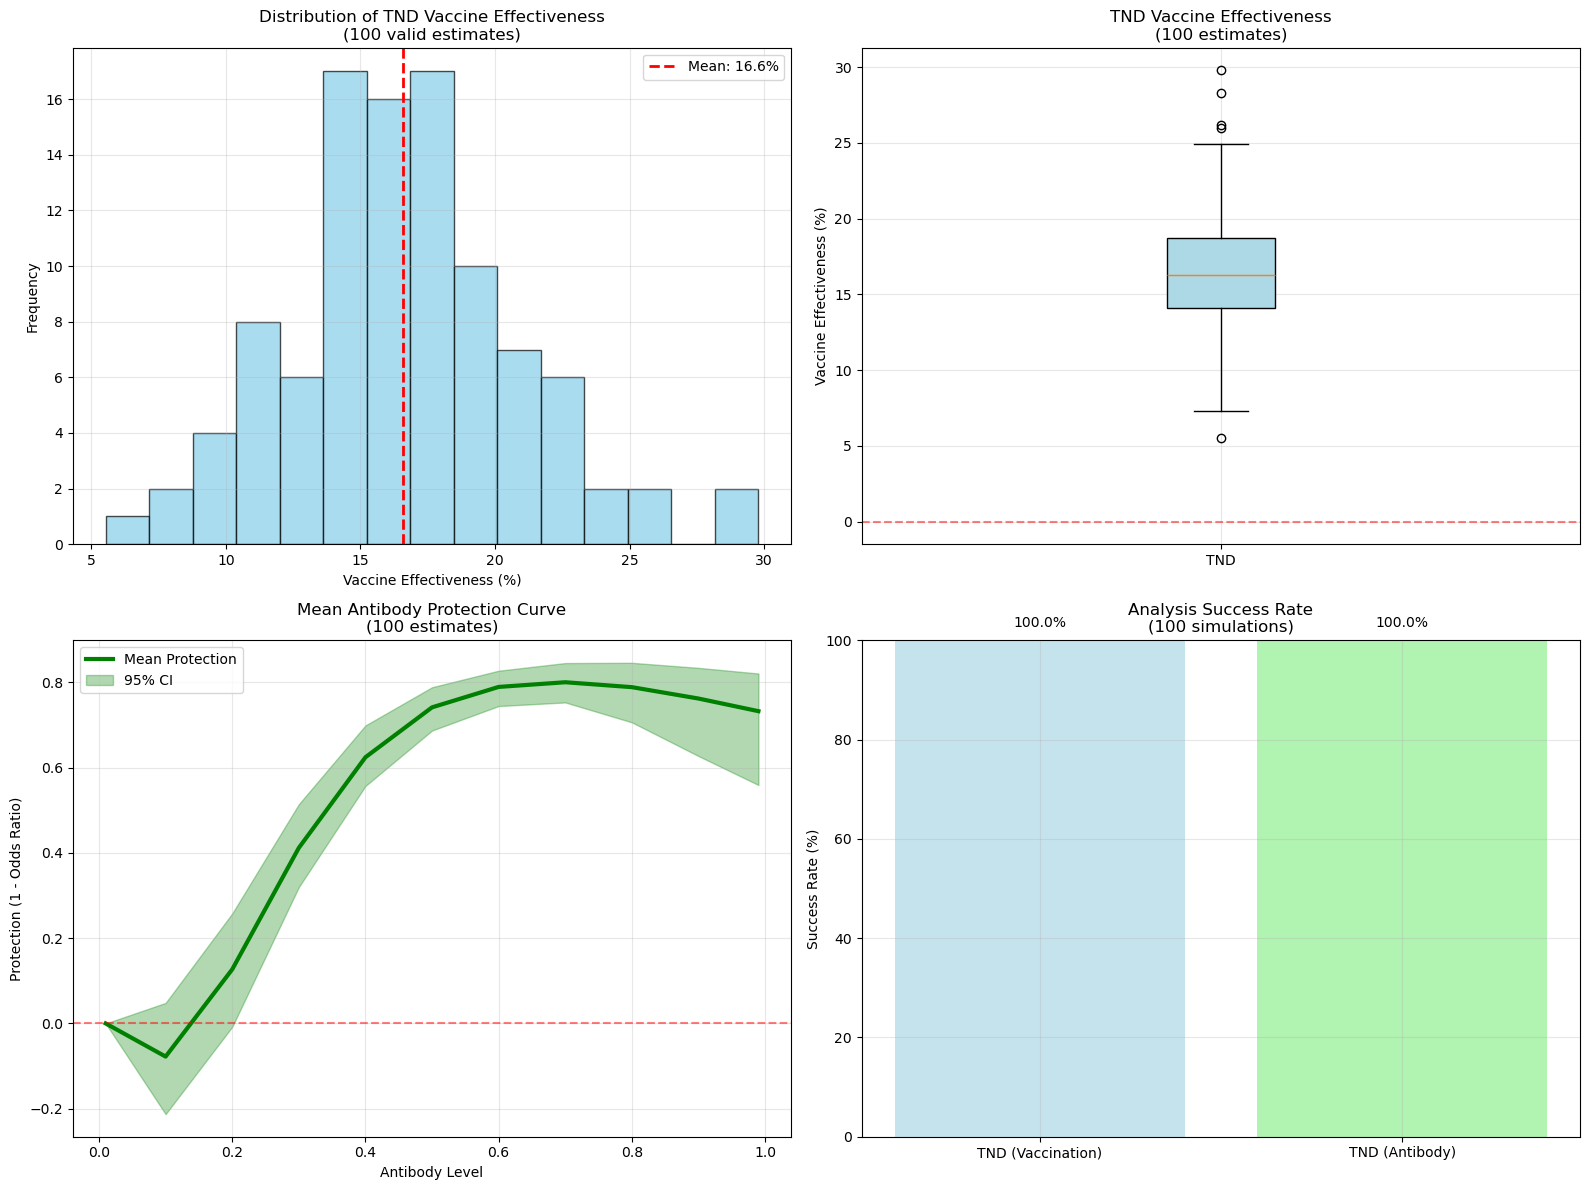


=== MONTE CARLO INSIGHTS ===
1. Test-negative design success depends on having sufficient tested individuals
2. Antibody-based analysis provides dose-response relationships when successful
3. Vaccination-based TND gives single-point vaccine effectiveness estimate
4. Monte Carlo quantifies uncertainty in both approaches
5. Higher success rates indicate more robust analytical approaches
6. Average protection ranges from -7.8% to 80.0%
7. Confidence intervals show uncertainty in dose-response relationship


In [7]:
a = np.linspace(.1, .9, 9)  # 10 points from 0 to 1
a = np.concatenate((.01, a, .99), axis = None)

antibody_grid = a
true_prot = scaled_logit(x = antibody_grid,  l = 0.9, a=3, b=-10)
antibody_distribution = mc_results['antibody_distribution']

# Calculate summary statistics
hr_values = [hr for hr in mc_results['hr_test_negative_design'] if hr is not None and not np.isnan(hr)]
ve_values = [(1 - hr) * 100 for hr in hr_values]

# Protection curves - only for runs that succeeded
valid_protection_curves_spline = [curve for curve in mc_results['protection_curve_spline'] if curve is not None]
valid_protection_curves_log = [curve for curve in mc_results['protection_curve_log'] if curve is not None]

# MSE + Bias
prot_spline = np.array([
    arr if arr is not None else np.full(len(PARAMS.get('antibody_grid', a)), np.nan)
    for arr in mc_results['protection_curve_spline']
])
prot_log = np.array([
    arr if arr is not None else np.full(len(PARAMS.get('antibody_grid', a)), np.nan)
    for arr in mc_results['protection_curve_log']
])

spline_stats = compute_bias_mse(prot_spline, true_prot, antibody_distribution )
log_stats = compute_bias_mse(prot_log, true_prot, antibody_distribution )


print("\n=== MONTE CARLO RESULTS ===")
if len(hr_values) > 0:
    print(f"\nTest Negative Design (Vaccination) - {len(hr_values)}/{n_simulations} valid estimates:")
    print(f"  Hazard Ratio: {np.mean(hr_values):.3f} ± {np.std(hr_values):.3f}")
    print(f"  HR 95% CI: [{np.percentile(hr_values, 2.5):.3f}, {np.percentile(hr_values, 97.5):.3f}]")
    print(f"  Vaccine Effectiveness: {np.mean(ve_values):.1f}% ± {np.std(ve_values):.1f}%")
    print(f"  VE 95% CI: [{np.percentile(ve_values, 2.5):.1f}%, {np.percentile(ve_values, 97.5):.1f}%]")
else:
    print(f"\nTest Negative Design: No valid estimates")

if len(valid_protection_curves_spline) > 0:
    print(f"\nAntibody-based Protection Curves - {len(valid_protection_curves_spline)}/{n_simulations} valid estimates:")
    
    # Calculate mean and confidence intervals for protection curves
    protection_array = np.array(valid_protection_curves_spline)
    mean_protection = np.mean(protection_array, axis=0)
    ci_lower = np.percentile(protection_array, 2.5, axis=0)
    ci_upper = np.percentile(protection_array, 97.5, axis=0)
    
    print(f"  Average protection curve available")
    print(f"  Range of protection: {np.min(mean_protection):.3f} to {np.max(mean_protection):.3f}")

    

# Create visualization of results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Distribution of vaccine effectiveness estimates
if len(ve_values) > 0:
    ax1.hist(ve_values, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(np.mean(ve_values), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(ve_values):.1f}%')
    ax1.set_xlabel('Vaccine Effectiveness (%)')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Distribution of TND Vaccine Effectiveness\n({len(ve_values)} valid estimates)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
else:
    ax1.text(0.5, 0.5, 'No valid VE estimates', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Distribution of TND Vaccine Effectiveness')

# Plot 2: Box plot of VE estimates
if len(ve_values) > 0:
    box_plot = ax2.boxplot([ve_values], patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightblue')
    ax2.set_ylabel('Vaccine Effectiveness (%)')
    ax2.set_title(f'TND Vaccine Effectiveness\n({len(ve_values)} estimates)')
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticklabels(['TND'])
else:
    ax2.text(0.5, 0.5, 'No valid estimates', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('TND Vaccine Effectiveness')

# Plot 3: Mean antibody-based protection curve with confidence intervals
if len(valid_protection_curves_spline) > 0:
    ax3.plot(antibody_grid, mean_protection, 'g-', linewidth=3, label='Mean Protection')
    ax3.fill_between(antibody_grid, ci_lower, ci_upper, alpha=0.3, color='green', label='95% CI')
    ax3.set_xlabel('Antibody Level')
    ax3.set_ylabel('Protection (1 - Odds Ratio)')
    ax3.set_title(f'Mean Antibody Protection Curve\n({len(valid_protection_curves_spline)} estimates)')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax3.legend()
else:
    ax3.text(0.5, 0.5, 'No valid protection curves', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Mean Antibody Protection Curve')

# Plot 4: Success rate of different analyses
analysis_names = ['TND (Vaccination)', 'TND (Antibody)']
success_rates = [
    len(hr_values) / n_simulations * 100,
    len(valid_protection_curves_spline) / n_simulations * 100
]

bars = ax4.bar(analysis_names, success_rates, alpha=0.7, 
               color=['lightblue', 'lightgreen'])
ax4.set_ylabel('Success Rate (%)')
ax4.set_title(f'Analysis Success Rate\n({n_simulations} simulations)')
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 100)

# Add value labels on bars
for bar, rate in zip(bars, success_rates):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{rate:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Reset random seed
np.random.seed(42)
random.seed(42)

print("\n=== MONTE CARLO INSIGHTS ===")
print("1. Test-negative design success depends on having sufficient tested individuals")
print("2. Antibody-based analysis provides dose-response relationships when successful")
print("3. Vaccination-based TND gives single-point vaccine effectiveness estimate")
print("4. Monte Carlo quantifies uncertainty in both approaches")
print("5. Higher success rates indicate more robust analytical approaches")

if len(valid_protection_curves_spline) > 0:
    print(f"6. Average protection ranges from {np.min(mean_protection)*100:.1f}% to {np.max(mean_protection)*100:.1f}%")
    print(f"7. Confidence intervals show uncertainty in dose-response relationship")


Antibody-based Protection Curves - 100/100 valid estimates:
  Average protection curve available
  Range of protection: 0.000 to 0.948
[[0.         0.0582238  0.12551445 ... 0.63455675 0.76375991 0.94454254]
 [0.         0.06492536 0.139366   ... 0.67582821 0.80104559 0.96069635]
 [0.         0.06967711 0.14911343 ... 0.70239077 0.82399145 0.96925603]
 ...
 [0.         0.05824195 0.12555212 ... 0.6346749  0.76386938 0.94459403]
 [0.         0.0475975  0.1032999  ... 0.5588462  0.6905707  0.90474462]
 [0.         0.07380412 0.15752956 ... 0.72378653 0.84184245 0.9751876 ]]
[0.         0.06102391 0.13123937 0.20441874 0.28115225 0.36227183
 0.44902295 0.54343987 0.64933794 0.77602584 0.94812247]


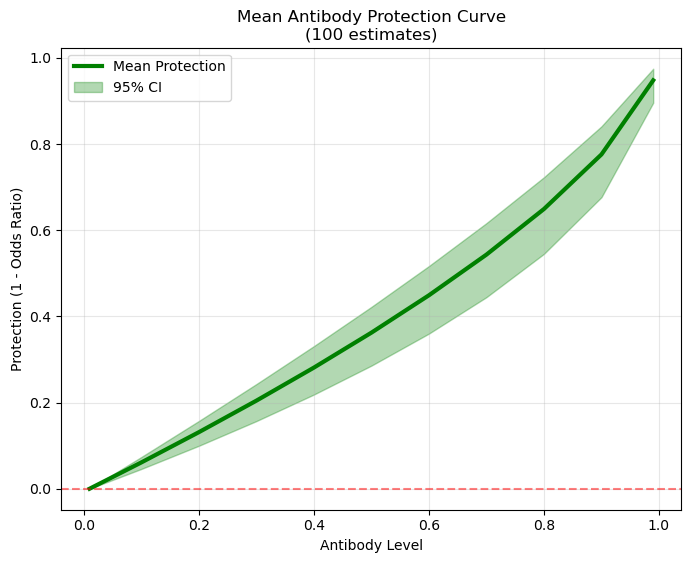

In [10]:
if len(valid_protection_curves_log) > 0:
    print(f"\nAntibody-based Protection Curves - {len(valid_protection_curves_log)}/{n_simulations} valid estimates:")
    
    # Calculate mean and confidence intervals for protection curves
    protection_array = np.array(valid_protection_curves_log)
    mean_protection = np.mean(protection_array, axis=0)
    ci_lower = np.percentile(protection_array, 2.5, axis=0)
    ci_upper = np.percentile(protection_array, 97.5, axis=0)
    
    print(f"  Average protection curve available")
    print(f"  Range of protection: {np.min(mean_protection):.3f} to {np.max(mean_protection):.3f}")

print(protection_array)
print(mean_protection)

fig, ax = plt.subplots(figsize=(8, 6)) 

# Mean antibody-based protection curve with confidence intervals
if len(valid_protection_curves_log) > 0:
    ax.plot(antibody_grid, mean_protection, 'g-', linewidth=3, label='Mean Protection')
    ax.fill_between(antibody_grid, ci_lower, ci_upper, alpha=0.3, color='green', label='95% CI')
    ax.set_xlabel('Antibody Level')
    ax.set_ylabel('Protection (1 - Odds Ratio)')
    ax.set_title(f'Mean Antibody Protection Curve\n({len(valid_protection_curves_log)} estimates)')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax.legend()
else:
    ax.text(0.5, 0.5, 'No valid protection curves', ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Mean Antibody Protection Curve')


plt.show()

# Reset random seed
np.random.seed(42)
random.seed(42)


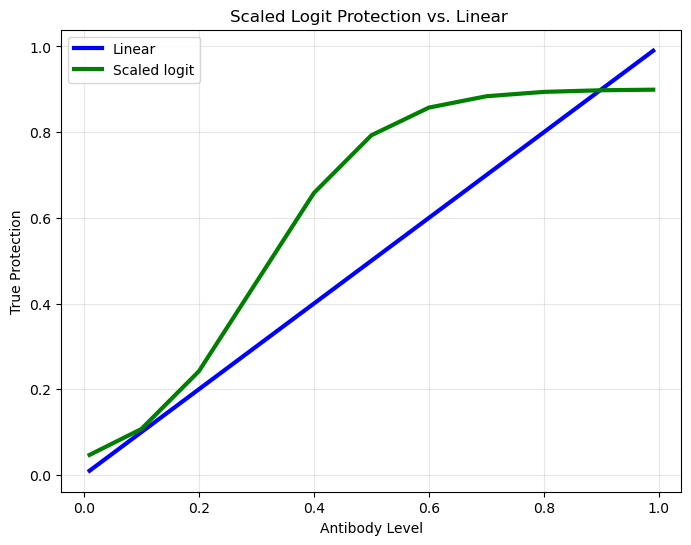

In [8]:
fig, ax = plt.subplots(figsize=(8, 6)) 
ax.plot(antibody_grid, antibody_grid, 'b-', linewidth=3, label = "Linear")
ax.plot(antibody_grid, true_prot, 'g-', linewidth=3, label = "Scaled logit")
ax.set_xlabel('Antibody Level')
ax.set_ylabel('True Protection')
ax.set_title(f'Scaled Logit Protection vs. Linear ')
ax.grid(True, alpha=0.3)
ax.legend()

In [9]:
print(mean_protection)

[ 0.         -0.07772729  0.12674917  0.41167498  0.62408853  0.74108794
  0.78898166  0.79995991  0.78844105  0.76175091  0.73213479]


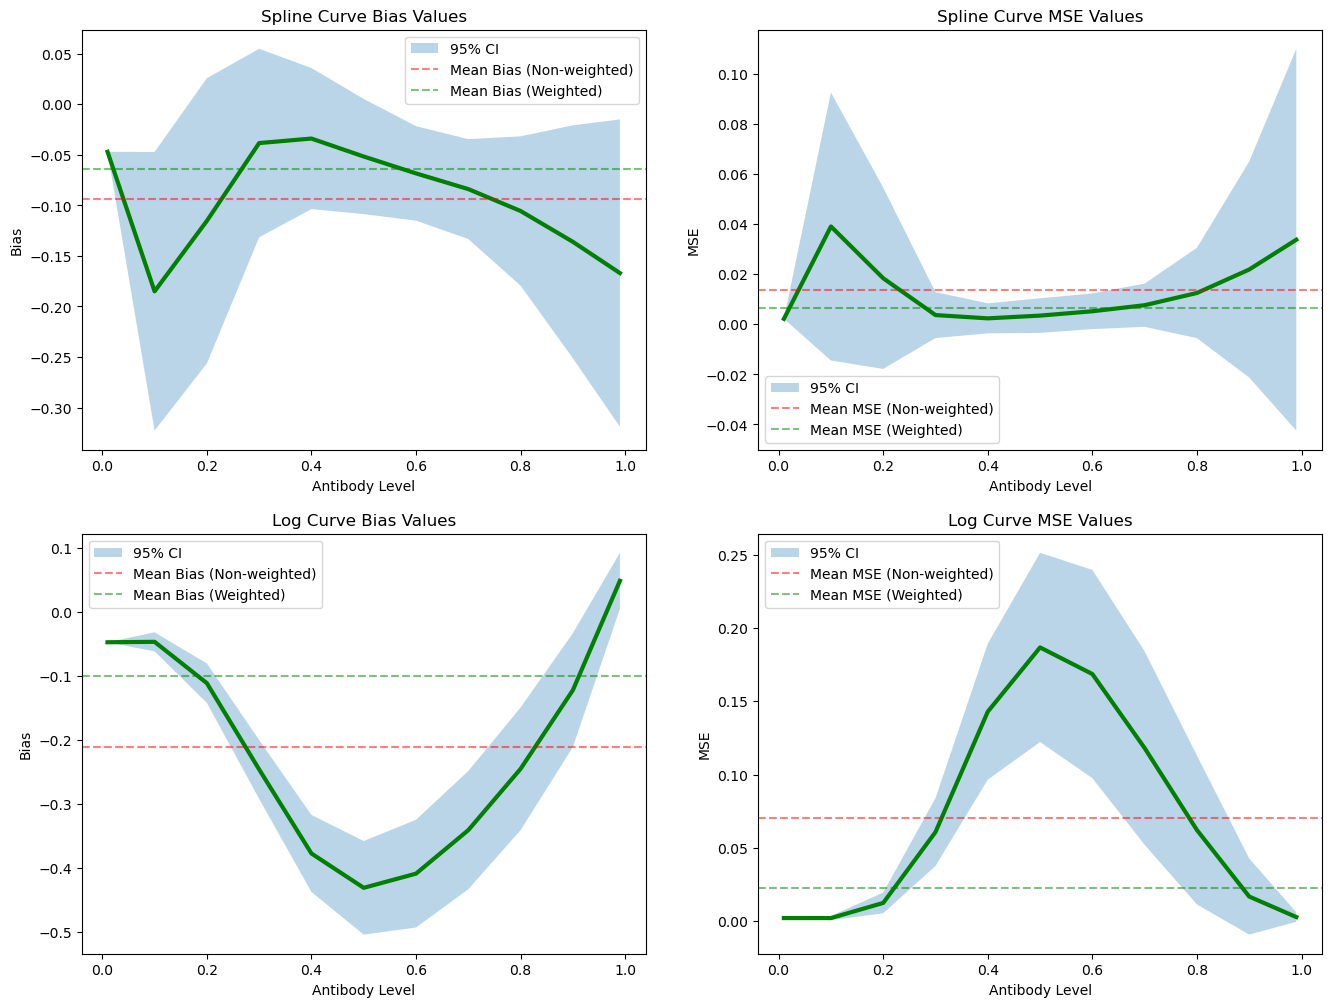

In [11]:

lower_bound_bias_spline = spline_stats['bias_vec'] - 1.96 *  spline_stats['se_bias']
upper_bound_bias_spline = spline_stats['bias_vec'] + 1.96 * spline_stats['se_bias']

lower_bound_bias_log = log_stats['bias_vec'] - 1.96 *  log_stats['se_bias']
upper_bound_bias_log = log_stats['bias_vec'] + 1.96 * log_stats['se_bias']


lower_bound_mse_spline = spline_stats['mse_vec'] - 1.96 *  spline_stats['se_mse']
upper_bound_mse_spline = spline_stats['mse_vec'] + 1.96 * spline_stats['se_mse']

lower_bound_mse_log = log_stats['mse_vec'] - 1.96 *  log_stats['se_mse']
upper_bound_mse_log = log_stats['mse_vec'] + 1.96 * log_stats['se_mse']


# Create visualization of results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

#Plot 1: Spline Bias
antibody_grid = results_basic['antibody_grid']
bias_vec_spline = spline_stats['bias_vec']
ax1.plot(antibody_grid, bias_vec_spline, 'g-', linewidth=3)
ax1.set_xlabel('Antibody Level')
ax1.set_ylabel('Bias')
ax1.set_title(f'Spline Curve Bias Values')
ax1.fill_between(antibody_grid, lower_bound_bias_spline, upper_bound_bias_spline, alpha=0.3, label='95% CI')
ax1.axhline(y=spline_stats['bias_overall'], color='red', linestyle='--', alpha=0.5, label='Mean Bias (Non-weighted)')
ax1.axhline(y=spline_stats['weighted_bias'], color='green', linestyle='--', alpha=0.5, label='Mean Bias (Weighted)')
ax1.legend()

#Plot 2: Spline MSE
antibody_grid = results_basic['antibody_grid']
mse_vec_spline = spline_stats['mse_vec']
ax2.plot(antibody_grid, mse_vec_spline, 'g-', linewidth=3)
ax2.set_xlabel('Antibody Level')
ax2.set_ylabel('MSE')
ax2.set_title(f'Spline Curve MSE Values')
ax2.fill_between(antibody_grid, lower_bound_mse_spline, upper_bound_mse_spline, alpha=0.3, label='95% CI')
ax2.axhline(y=spline_stats['mse_overall'], color='red', linestyle='--', alpha=0.5, label='Mean MSE (Non-weighted)')
ax2.axhline(y=spline_stats['weighted_mse'], color='green', linestyle='--', alpha=0.5, label='Mean MSE (Weighted)')
ax2.legend()

#Plot 3: Log Bias
antibody_grid = results_basic['antibody_grid']
bias_vec_log = log_stats['bias_vec']
ax3.plot(antibody_grid, bias_vec_log, 'g-', linewidth=3)
ax3.set_xlabel('Antibody Level')
ax3.set_ylabel('Bias')
ax3.set_title(f'Log Curve Bias Values')
ax3.fill_between(antibody_grid, lower_bound_bias_log, upper_bound_bias_log, alpha=0.3, label='95% CI')
ax3.axhline(y=log_stats['bias_overall'], color='red', linestyle='--', alpha=0.5, label='Mean Bias (Non-weighted)')
ax3.axhline(y=log_stats['weighted_bias'], color='green', linestyle='--', alpha=0.5, label='Mean Bias (Weighted)')
ax3.legend()

#Plot 4: Log MSE
antibody_grid = results_basic['antibody_grid']
mse_vec_log = log_stats['mse_vec']
ax4.plot(antibody_grid, mse_vec_log, 'g-', linewidth=3)
ax4.set_xlabel('Antibody Level')
ax4.set_ylabel('MSE')
ax4.set_title(f'Log Curve MSE Values')
ax4.fill_between(antibody_grid, lower_bound_mse_log, upper_bound_mse_log, alpha=0.3, label='95% CI')
ax4.axhline(y=log_stats['mse_overall'], color='red', linestyle='--', alpha=0.5, label='Mean MSE (Non-weighted)')
ax4.axhline(y=log_stats['weighted_mse'], color='green', linestyle='--', alpha=0.5, label='Mean MSE (Weighted)')
ax4.legend()

In [12]:
bias_vec_spline = spline_stats['bias_vec']
mse_vec_spline =  spline_stats['mse_vec']
bias_vec_log = log_stats['bias_vec']
mse_vec_log =  log_stats['mse_vec']
column_names = ['Antibody Levels'] + [str(x)[:5] for x in antibody_grid]+['Overall (simple)', 'Overall (weighted)']
spline_bias_means = [spline_stats['bias_overall'],spline_stats['weighted_bias']]
spline_mse_means = [spline_stats['mse_overall'],spline_stats['weighted_mse']]
log_bias_means = [log_stats['bias_overall'],log_stats['weighted_bias']]
log_mse_means = [log_stats['mse_overall'],log_stats['weighted_mse']]

spline_bias = np.concatenate([bias_vec_spline, spline_bias_means]) 
spline_mse = np.concatenate([mse_vec_spline, spline_mse_means]) 
log_bias = np.concatenate([bias_vec_log, log_bias_means]) 
log_mse = np.concatenate([mse_vec_log, log_mse_means]) 

table_data = [
    ['Spline'] + [''] * (len(column_names) - 1),
    ['Bias'] + spline_bias.tolist(),
    ['Bias SE'] + spline_stats['se_bias'].tolist(),
    ['MSE'] + spline_mse.tolist(),
    ['MSE SE'] + spline_stats['se_mse'].tolist(),
    ['Log'] + [''] * (len(column_names) - 1),
    ['Bias'] + log_bias.tolist(),
    ['Bias SE'] + log_stats['se_bias'].tolist(),
    ['MSE'] + log_mse.tolist(),
    ['MSE SE'] + log_stats['se_mse'].tolist()
]

df = pd.DataFrame(table_data, columns=column_names)

#print(df)

from IPython.display import display

display(df)

,Antibody Levels,0.01,0.1,0.2,0.300,0.4,0.5,0.6,0.700,0.8,0.9,0.99,Overall (simple),Overall (weighted)
0,Spline,,,,,,,,,,,,,
1,Bias,-0.046938,-0.18501,-0.115298,-0.038325,-0.033864,-0.051629,-0.068335,-0.083852,-0.105535,-0.136024,-0.166959,-0.093797,-0.063831
2,Bias SE,0.0,0.070323,0.072019,0.047577,0.035617,0.02907,0.023851,0.025226,0.037684,0.058804,0.077565,None,None
3,MSE,0.002203,0.039125,0.018428,0.00371,0.002403,0.003502,0.005233,0.007661,0.012544,0.021926,0.033831,0.013688,0.006447
4,MSE SE,0.0,0.027333,0.018495,0.004683,0.003067,0.003531,0.003635,0.004416,0.009216,0.022039,0.038935,None,None
5,Log,,,,,,,,,,,,,
6,Bias,-0.046938,-0.046259,-0.110808,-0.245581,-0.3768,-0.430446,-0.408294,-0.340373,-0.244638,-0.121749,0.049029,-0.211169,-0.099866
7,Bias SE,0.0,0.007583,0.015718,0.023468,0.030717,0.037293,0.042922,0.047114,0.048867,0.045401,0.022304,None,None
8,MSE,0.002203,0.002197,0.012523,0.060855,0.142913,0.18666,0.168528,0.118051,0.062212,0.016863,0.002896,0.070537,0.023004
9,MSE SE,0.0,0.000729,0.003605,0.011804,0.023651,0.032905,0.036215,0.033652,0.025892,0.01324,0.001648,None,None


## Conclusion

This notebook demonstrated how to use the test-negative design simulation framework with antibody dynamics to:

1. **Model antibody-mediated protection** with vaccination and infection effects, plus waning immunity over time
2. **Focus on test-negative design analysis** using antibody levels measured at the time of testing  
3. **Generate spline-based dose-response curves** showing protection across antibody levels
4. **Compare vaccination-based and antibody-based approaches** within the TND framework
5. **Quantify uncertainty** using Monte Carlo simulation for robust inference

### Key Insights:
- **Antibody levels at testing provide direct dose-response relationships** between immunity and protection
- **Spline-based modeling allows flexible, non-linear protection curves** rather than assuming linear relationships
- **Test-negative design is most appropriate** when antibody levels are measured at time of testing
- **Waning immunity significantly affects** both antibody levels and epidemic dynamics over time
- **Monte Carlo simulation quantifies uncertainty** in both vaccination-based and antibody-based estimates

### Model Features:
- **Realistic immunity dynamics**: Antibody levels peak after vaccination/infection and wane over time
- **Pathogen-specific effects**: Vaccine only affects test-positive pathogen, creating proper control conditions
- **Temporal precision**: Uses antibody levels measured at exact time of testing, not final levels
- **Flexible dose-response**: Spline-based modeling captures non-linear antibody-protection relationships

### Key Methodological Advances:
- **Focus on TND**: Removed Cox models and difference-in-differences that don't match antibody timing
- **Antibody-based analysis**: Primary focus on antibody levels as continuous exposure variable
- **Spline modeling**: Flexible dose-response curves rather than binary vaccination effects
- **Temporal alignment**: Antibody levels measured when testing occurs, matching real-world studies

### Next Steps:
- Experiment with **different spline specifications** (number of knots, degree)
- Test **alternative antibody-protection relationships** (non-linear, threshold effects)
- Incorporate **measurement error** in antibody levels
- Add **time-varying antibody effects** (recent vs distant vaccination/infection)
- Explore **optimal sampling strategies** for antibody-based TND studies

### Usage Tips:
- Focus on **test-negative design** as the primary analysis when antibody data available
- Use **vaccination-based TND** for comparison and validation
- Increase `n_simulations` for more robust confidence intervals (50-100 recommended)
- Monitor **success rates** - low rates may indicate insufficient sample sizes or rare outcomes
- Examine **dose-response curves** for biological plausibility and consistency across simulations

This framework provides a realistic simulation environment for designing and analyzing antibody-based test-negative design studies, with proper attention to the temporal relationship between antibody measurement and testing outcomes.